In [2]:
!pip install transformers
!pip install datasets
!pip install umap-learn
!pip install sentencepiece

In [3]:
from transformers import AutoModelForSequenceClassification
from datasets import load_dataset
from transformers import AutoTokenizer, AutoConfig
from transformers import AutoModel
from torch import torch
import pandas as pd
import matplotlib.pyplot as plt

from datasets import Dataset, DatasetDict, 
from datasets import ClassLabel, concatenate_datasets
from datasets import Dataset, ClassLabel, Features, Value

import datasets
import pandas as pd

In [4]:
TEXT_COL      = 'text'
CLASS_COL_ST1 = 'label'

In [6]:
extended_df = load_dataset("cardiffnlp/tweet_sentiment_multilingual", 'spanish')

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset tweet_sentiment_multilingual downloaded and prepared to C:/Users/OWNER/.cache/huggingface/datasets/cardiffnlp___tweet_sentiment_multilingual/spanish/0.1.0/936afd3cde120393429606f681b3b48d526873c45114068973f71e296ce80605. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [7]:
display(extended_df)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 1839
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 324
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 870
    })
})

In [57]:
# descomente la siguiente línea para leer datos desde un URL

train_url = 'https://raw.githubusercontent.com/carlossuazo/davincis-iberlef-2023/main/data/training_data/train.csv'
test_url = 'https://raw.githubusercontent.com/carlossuazo/davincis-iberlef-2023/main/data/test_data/test.csv'

# Dataset de entrenamiento
df_train = pd.read_csv(train_url, header=None, names = [TEXT_COL, CLASS_COL_ST1])

# Dataset de test
df_test  = pd.read_csv(test_url, header=None, names = [TEXT_COL, CLASS_COL_ST1])

display(df_train)
display(df_test)

,text,label
0,#Ahora | Reportan accidente de tránsito en el ...,harmful
1,#PrecauciónVial en #CDMX se registra cierre pa...,neutral
2,#traficogt 🚨🚨👉 http 3. Se realizan trabajos ...,neutral
3,#HoyMismo #Internacionales | El Gobierno de J...,neutral
4,"Casos como el accidente en Villa Lorena, en el...",neutral
...,...,...
3357,"Bomberos atendieron accidente vehicular, vía h...",harmful
3358,El @user y @user recuerdan al escritor Eraclio...,neutral
3359,Recientemente lo dejaron libre bajo fianza y a...,harmful
3360,Accidente en Calle 127 &gt; Oriente #traficobo...,neutral


,text,label
0,Accidente en el Vallado frente al polideportiv...,harmful
1,Vitor Belfort abruma a Evander Holyfield en la...,neutral
2,"En México, las estadísticas de violencia homic...",neutral
3,"Como Jorge Armando Ayala Guarín de 25 años, f...",harmful
4,Quebrar un vidrio ///// Quebrar el país a plom...,neutral
5,"#EsNoticia 📌 En aparente estado de embriaguez,...",harmful
6,@user Por último ponga la queja en CNN en espa...,neutral
7,174 aniversario de la Gesta Heroica de los Niñ...,neutral
8,SigAlert en Lake Elsinore. En la I-15 norte ce...,neutral
9,LO ÚLTIMO Al menos dos personas resultaron her...,harmful


In [58]:
df = DatasetDict({
    "train": Dataset.from_pandas(df_train, features=Features({'text': Value('string'),'label': ClassLabel(names=['harmful', 'neutral'])})),
    "validation": Dataset.from_pandas(df_test, features=Features({'text': Value('string'),'label': ClassLabel(names=['harmful', 'neutral'])}))
    })

In [59]:
df

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 3362
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 50
    })
})

In [60]:
df['train'].features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['harmful', 'neutral'], id=None)}

In [61]:
model_ckpt = f"cardiffnlp/twitter-roberta-base-sentiment"#"cardiffnlp/twitter-xlm-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [62]:
text = 'Tokenizar el texto es una tarea central del NLP.'
encoded_text = tokenizer(text)
print(encoded_text)

{'input_ids': [0, 45643, 1210, 271, 1615, 2788, 139, 2714, 542, 102, 326, 7907, 1353, 2424, 234, 21992, 4, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [63]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)

['<s>', 'Token', 'iz', 'ar', 'Ġel', 'Ġtext', 'o', 'Ġes', 'Ġun', 'a', 'Ġt', 'area', 'Ġcentral', 'Ġdel', 'ĠN', 'LP', '.', '</s>']


In [64]:
print(tokenizer.convert_tokens_to_string(tokens))

<s>Tokenizar el texto es una tarea central del NLP.</s>


In [65]:
tokenizer.vocab_size

50265

In [66]:
tokenizer.model_max_length

1000000000000000019884624838656

In [67]:
tokenizer.model_input_names

['input_ids', 'attention_mask']

In [68]:
def tokenize(batch):
    return tokenizer(batch[TEXT_COL], padding=True, truncation=True)

In [69]:
print(tokenize(df["train"][:2]))

{'input_ids': [[0, 10431, 17986, 4330, 1721, 2872, 260, 3213, 242, 263, 2664, 1526, 6852, 4842, 1177, 1615, 21691, 1535, 139, 1076, 40492, 1020, 263, 2575, 438, 1176, 1526, 4, 25840, 27102, 1977, 13300, 366, 4767, 139, 1893, 1517, 40645, 3964, 7822, 366, 1177, 1615, 228, 438, 5332, 4, 1437, 27672, 1180, 2520, 2727, 1076, 46341, 853, 2953, 1615, 1293, 4, 1437, 37522, 118, 1322, 14666, 897, 6296, 5014, 2727, 4, 1437, 1437, 8103, 9085, 18537, 15286, 6320, 15775, 271, 16723, 366, 1437, 849, 5320, 41312, 1866, 7199, 636, 5003, 1437, 2054, 2], [0, 10431, 22763, 438, 1180, 2520, 2727, 846, 2617, 1177, 849, 11579, 39810, 842, 19886, 763, 740, 41307, 2242, 15585, 263, 27884, 922, 5014, 2727, 2953, 3213, 242, 6, 10, 4892, 1178, 757, 625, 5511, 242, 1177, 1615, 6301, 321, 844, 2744, 2965, 23434, 6377, 36, 1360, 1749, 43, 26617, 1178, 2684, 36, 30495, 4, 11242, 405, 5781, 1342, 293, 43, 1587, 1127, 15017, 102, 6, 21230, 139, 2664, 12705, 6, 10697, 12870, 2727, 7522, 39810, 4, 497, 118, 15205, 3117

In [70]:
tweets_encoded = df.map(tokenize, batched=True, batch_size=None) #batch_size=None

Map:   0%|          | 0/3362 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

In [71]:
# al aplicar map se agregan dos nuevas columnas al objeto, 
print(tweets_encoded["train"].column_names)

['text', 'label', 'input_ids', 'attention_mask']


In [72]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

In [73]:
from transformers import TFAutoModel

#tf_model = TFAutoModel.from_pretrained(model_ckpt)

In [74]:
#tf_xlmr = TFAutoModel.from_pretrained("xlm-roberta-base")

In [75]:
#tf_xlmr = TFAutoModel.from_pretrained("xlm-roberta-base", from_pt=True)

In [76]:
text = "this is a test"
inputs = tokenizer(text, return_tensors="pt")
print(f"Input tensor shape: {inputs['input_ids'].size()}")

Input tensor shape: torch.Size([1, 6])


In [77]:
inputs = {k:v.to(device) for k,v in inputs.items()}
with torch.no_grad():
    outputs = model(**inputs)
print(outputs)

BaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=tensor([[[-2.8212e-01, -5.4723e-01,  8.7227e-02,  ..., -6.1494e-01,
          -1.0628e-01, -6.2300e-01],
         [ 3.5916e-02, -8.6982e-01,  5.3141e-01,  ..., -7.1903e-01,
          -1.2872e-01, -2.8742e-01],
         [-9.1783e-02,  3.6813e-04,  1.3581e-01,  ..., -1.3801e+00,
          -2.0054e-01, -3.4173e-02],
         [ 1.5421e-02, -6.7264e-01,  1.4242e-01,  ..., -4.3557e-01,
           2.9332e-01, -1.9288e-01],
         [-5.2928e-02, -5.2406e-01,  2.5271e-01,  ..., -1.0034e+00,
           1.6826e-01, -4.1093e-01],
         [-2.9693e-01, -5.4961e-01,  8.7612e-02,  ..., -6.1877e-01,
          -1.0939e-01, -6.3301e-01]]]), pooler_output=tensor([[ 6.0533e-01, -4.4612e-01,  1.3868e-01,  5.2908e-01, -1.4114e-01,
          3.1448e-01,  8.3066e-01,  3.1738e-01, -6.7557e-01,  2.2000e-01,
         -6.1351e-01, -1.8779e-01, -4.9827e-01,  2.2901e-01,  1.4920e-01,
         -3.4883e-01, -4.8575e-01,  8.3031e-02,  4.4950e-01, -5.3882

In [78]:
outputs.last_hidden_state.size()

torch.Size([1, 6, 768])

In [79]:
outputs.last_hidden_state[:,0].size()

torch.Size([1, 768])

In [80]:
def extract_hidden_states(batch):
    # Place model inputs on the GPU
    inputs = {k:v.to(device) for k,v in batch.items()
              if k in tokenizer.model_input_names}
    # Extract last hidden states
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    # Return vector for [CLS] token
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}
# def extract_hidden_states(batch):
#     # Place model inputs on the GPU
#     inputs = {k: torch.tensor(v).to(device) if isinstance(v, list) else v.to(device)
#               for k,v in batch.items()
#               if k in tokenizer.model_input_names}
#     # Extract last hidden states
#     with torch.no_grad():
#         last_hidden_state = model(**inputs).last_hidden_state
#     # Return vector for [CLS] token
#     return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

In [81]:
tweets_encoded.set_format("torch",  columns=["input_ids", "attention_mask", CLASS_COL_ST1])

In [82]:
tweets_hidden = tweets_encoded.map(extract_hidden_states, batched=True)

Map:   0%|          | 0/3362 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

In [83]:
def label_int2str(row):
    return df["train"].features[CLASS_COL_ST1].int2str(row)

In [84]:
tweets_hidden["train"].column_names

['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

In [85]:
import numpy as np

X_train = np.array(tweets_hidden["train"]["hidden_state"])
X_valid = np.array(tweets_hidden["test"]["hidden_state"])
y_train = np.array(tweets_hidden["train"][CLASS_COL_ST1])
y_valid = np.array(tweets_hidden["test"][CLASS_COL_ST1])
X_train.shape, X_valid.shape

((3362, 768), (50, 768))

In [86]:
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler

# Scale features to [0,1] range
X_scaled = MinMaxScaler().fit_transform(X_train)
# Initialize and fit UMAP
mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)
# Create a DataFrame of 2D embeddings
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb[CLASS_COL_ST1] = y_train
df_emb.head()

,X,Y,label
0,7.160400,9.946771,0
1,8.302866,8.803260,1
2,9.449741,9.917082,1
3,10.141050,14.586168,1
4,8.588529,11.596406,1


In [87]:
df['train'].features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['harmful', 'neutral'], id=None)}

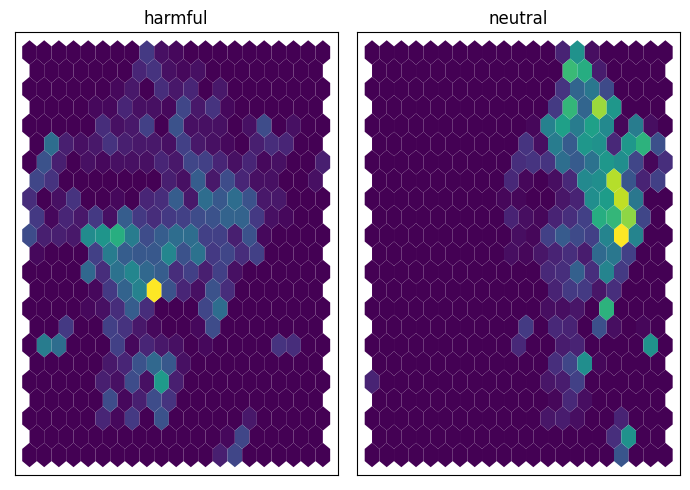

In [97]:
fig, axes = plt.subplots(1, 2, figsize=(7,5))
axes = axes.flatten()
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens"]
labels = df["train"].features["label"].names

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f"label == {i}")
    axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"],# cmap=cmap,
                   gridsize=20, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])

plt.tight_layout()
plt.show()

In [94]:
from sklearn.linear_model import LogisticRegression

# We increase `max_iter` to guarantee convergence
lr_clf = LogisticRegression(max_iter=5000)
lr_clf.fit(X_train, y_train)
lr_clf.score(X_valid, y_valid)

0.82

In [95]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_valid, y_valid)

0.54

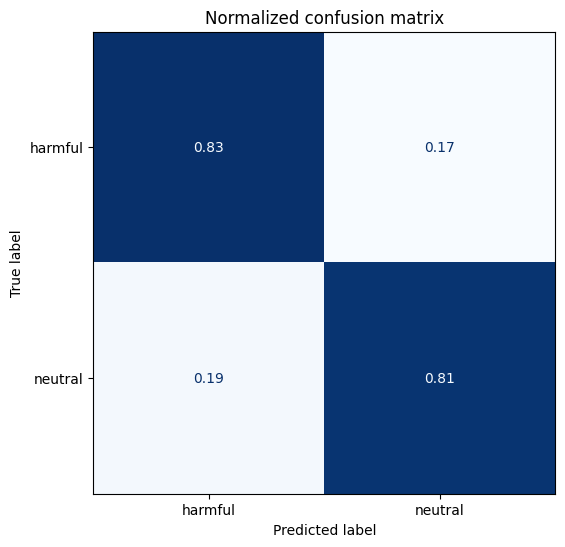

In [96]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels)

In [45]:
from transformers import AutoModelForSequenceClassification

num_labels = 2
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt, num_labels=num_labels, ignore_mismatched_sizes=True)
         .to(device))

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [46]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [47]:
from huggingface_hub import notebook_login

notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (manager-core).
Your token has been saved to C:\Users\OWNER\.cache\huggingface\token
Login successful


In [52]:
from transformers import Trainer, TrainingArguments

batch_size = 16
logging_steps = len(tweets_encoded["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-emotion"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=3,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=True,
                                  log_level="error")

In [53]:
from transformers import Trainer

trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=tweets_encoded["train"],
                  eval_dataset=tweets_encoded["test"],
                  tokenizer=tokenizer)
trainer.train();

Cloning https://huggingface.co/csuazob/twitter-roberta-base-sentiment-finetuned-emotion into local empty directory.
c:\Users\OWNER\anaconda3\envs\nlpbook\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/633 [00:00<?, ?it/s]

{'loss': 0.5708, 'learning_rate': 1.3364928909952607e-05, 'epoch': 1.0}


  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_loss': 0.6440387964248657, 'eval_accuracy': 0.7, 'eval_f1': 0.6944191814799504, 'eval_runtime': 5.2855, 'eval_samples_per_second': 9.46, 'eval_steps_per_second': 0.757, 'epoch': 1.0}
{'loss': 0.4539, 'learning_rate': 6.729857819905213e-06, 'epoch': 1.99}


  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_loss': 0.46936413645744324, 'eval_accuracy': 0.8, 'eval_f1': 0.7990259740259741, 'eval_runtime': 4.9853, 'eval_samples_per_second': 10.03, 'eval_steps_per_second': 0.802, 'epoch': 2.0}
{'loss': 0.3921, 'learning_rate': 9.478672985781992e-08, 'epoch': 2.99}


  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_loss': 0.5680455565452576, 'eval_accuracy': 0.74, 'eval_f1': 0.735163290615957, 'eval_runtime': 5.455, 'eval_samples_per_second': 9.166, 'eval_steps_per_second': 0.733, 'epoch': 3.0}
{'train_runtime': 7532.0536, 'train_samples_per_second': 1.339, 'train_steps_per_second': 0.084, 'train_loss': 0.4710910001072273, 'epoch': 3.0}
